In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import json
import itertools
from pandas.io.json import json_normalize

## INICIO DA COLETA DE DADOS

#### Retorna a categoria do local

In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    return categories_list[0]['name']

#### Informações para acessar a API do foursquare

In [ ]:
CLIENT_ID = '55LWIFZLZNZPSTAZZQKJXBD11BSBCUZTZPIXWVV4RFZJP1HS' # your Foursquare ID
CLIENT_SECRET = 'RPCOWGHQY5YNQUCHQUTC5VLKEYFGZN15FSIYTK5GNXNZ301E' # your Foursquare Secret
VERSION = '20180604'

#### Informações da cidade delimitada

In [ ]:
latitude_nyork = 40.730610
longitude_nyork = -73.935242
radius = 5000
LIMIT = 1000

#### Coleta checkins em bares

In [ ]:
QUERY = 'beer'
url = 'https://api.foursquare.com/v2/venues/search?intent=checkin&query={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    QUERY, CLIENT_ID, CLIENT_SECRET, latitude_nyork, longitude_nyork, VERSION, radius, LIMIT)
results = requests.get(url).json()
bares = results['response']['venues'] 
bares_proximos = json_normalize(bares)
filtered_columns = ['id', 'name', 'categories', 'location.lat', 'location.lng']
bares_proximos = bares_proximos.loc[:, filtered_columns]
bares_proximos['categories'] = bares_proximos.apply(get_category_type, axis=1)
bares_proximos.columns = [col.split(".")[-1] for col in bares_proximos.columns]
bares_proximos.tail(10)

#### Coleta checkins em sorveterias

In [ ]:
QUERY = 'icecream'
url = 'https://api.foursquare.com/v2/venues/search?intent=checkin&query={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    QUERY, CLIENT_ID, CLIENT_SECRET, latitude_nyork, longitude_nyork, VERSION, radius, LIMIT)
results = requests.get(url).json()
sorveterias = results['response']['venues'] 
sorveterias_proximas = json_normalize(sorveterias)
filtered_columns = ['id', 'name', 'categories', 'location.lat', 'location.lng']
sorveterias_proximas = sorveterias_proximas.loc[:, filtered_columns]
sorveterias_proximas['categories'] = sorveterias_proximas.apply(get_category_type, axis=1)
sorveterias_proximas.columns = [col.split(".")[-1] for col in sorveterias_proximas.columns]
sorveterias_proximas.tail(10)

#### Pega as pessoas que deram checkins nos locais

In [ ]:
checkins_bares = pd.DataFrame()
for bar in bares_proximos.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}&limit={}'.format(
    bar[1]['id'], CLIENT_ID, CLIENT_SECRET, VERSION, 2000)
    results = requests.get(url).json()
    if (results['response']['likes']['count'] > 0) & ('items' in results['response']['likes']):
        results_2 = results['response']['likes']['items']
        checkins = json_normalize(results_2)[['id', 'firstName', 'gender']]
        checkins['avenue_id'] = bar[1]['id']
        checkins['avenue_name'] = bar[1]['name']
        checkins['avenue_categories'] = bar[1]['categories']
        checkins['avenue_lat'] = bar[1]['lat']
        checkins['avenue_lng'] = bar[1]['lng']
        if checkins_bares.empty:
            checkins_bares = checkins
        else:
            checkins_bares = pd.concat([checkins_bares, checkins], ignore_index=True)

In [ ]:
checkins_sorveterias = pd.DataFrame()
for sorveteria in sorveterias_proximas.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}&limit={}'.format(
    sorveteria[1]['id'], CLIENT_ID, CLIENT_SECRET, VERSION, 2000)
    results = requests.get(url).json()
    if (results['response']['likes']['count'] > 0) & ('items' in results['response']['likes']):
        results_2 = results['response']['likes']['items']
        checkins = json_normalize(results_2)[['id', 'firstName', 'gender']]
        checkins['avenue_id'] = sorveteria[1]['id']
        checkins['avenue_name'] = sorveteria[1]['name']
        checkins['avenue_categories'] = sorveteria[1]['categories']
        checkins['avenue_lat'] = sorveteria[1]['lat']
        checkins['avenue_lng'] = sorveteria[1]['lng']
        if checkins_bares.empty:
            checkins_sorveterias = checkins
        else:
            checkins_sorveterias = pd.concat([checkins_sorveterias, checkins], ignore_index=True)

#### Salva os checkins encontrados

In [ ]:
checkins_bares.to_csv('victor_bares_checkins.csv', index=False)
checkins_sorveterias.to_csv('victor_sorveterias_checkins.csv', index=False)

## FINAL DA COLETA DE DADOS

## INICIO DA CRIACAO DO GRAFO

#### Lê os checkins coletados

In [3]:
checkins_bares = pd.read_csv('victor_bares_checkins.csv', encoding = 'utf8')
checkins_sorveterias = pd.read_csv('victor_sorveterias_checkins.csv', encoding = 'utf8')

In [4]:
checkins_bares.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
8746,222574700,Kayla,female,565cbec4498e7ec1b08e8182,Norwinds Beer Garden,Beer Garden,40.704114,-73.930618
8747,20635813,Victor,male,57339ff5498ebbf28b9eb4a2,Beer Garden Dazzler Brooklyn Hotel,Beer Garden,40.696674,-73.984278
8748,44828230,Ipek,female,57339ff5498ebbf28b9eb4a2,Beer Garden Dazzler Brooklyn Hotel,Beer Garden,40.696674,-73.984278
8749,16359325,Gokhan,male,57339ff5498ebbf28b9eb4a2,Beer Garden Dazzler Brooklyn Hotel,Beer Garden,40.696674,-73.984278
8750,435922162,Edna,female,57339ff5498ebbf28b9eb4a2,Beer Garden Dazzler Brooklyn Hotel,Beer Garden,40.696674,-73.984278


In [5]:
checkins_sorveterias.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
9824,1164105,nicole,female,553bf653498eba55ec0bdfde,Davey's Ice Cream,Ice Cream Shop,40.717053,-73.958606
9825,3419205,David,male,553bf653498eba55ec0bdfde,Davey's Ice Cream,Ice Cream Shop,40.717053,-73.958606
9826,42786540,Damian,male,553bf653498eba55ec0bdfde,Davey's Ice Cream,Ice Cream Shop,40.717053,-73.958606
9827,126871932,Davey's Ice Cream,none,553bf653498eba55ec0bdfde,Davey's Ice Cream,Ice Cream Shop,40.717053,-73.958606
9828,97046361,Susan,female,4ddc274e887775ea9c3acbe9,New York Soft Serve Ice Cream Truck,Ice Cream Shop,40.742296,-73.946989


#### Pegar os 5 bares com mais checkins

In [23]:
checkins_bares_value_counts = checkins_bares['avenue_id'].value_counts()
checkins_bares_value = checkins_bares_value_counts[:5].index

#### Pegar as 5 sorveterias com mais checkins

In [24]:
checkins_sorveterias_value_counts = checkins_sorveterias['avenue_id'].value_counts()
checkins_sorveterias_value = checkins_sorveterias_value_counts[:5].index

#### Juntar os bares e sorveterias

In [25]:
checkins_locais = itertools.chain(checkins_bares_value, checkins_sorveterias_value)

In [26]:
checkins_locais = list(checkins_locais)

#### Pega os checkins apenas desses locais

In [27]:
checkins_completo = pd.concat([checkins_bares, checkins_sorveterias])

In [28]:
checkins_completo = checkins_completo[checkins_completo['avenue_id'].isin(checkins_locais)]

In [29]:
checkins_completo.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
5844,8545524,Brad,male,518a87b3454aef48b51a84ce,OddFellows Ice Cream Co.,Ice Cream Shop,40.718194,-73.963985
5845,11558696,Laura,none,518a87b3454aef48b51a84ce,OddFellows Ice Cream Co.,Ice Cream Shop,40.718194,-73.963985
5846,156897,Eric,male,518a87b3454aef48b51a84ce,OddFellows Ice Cream Co.,Ice Cream Shop,40.718194,-73.963985
5847,868065,John,male,518a87b3454aef48b51a84ce,OddFellows Ice Cream Co.,Ice Cream Shop,40.718194,-73.963985
5848,1805429,jessica m.,female,518a87b3454aef48b51a84ce,OddFellows Ice Cream Co.,Ice Cream Shop,40.718194,-73.963985


#### Pega os IDs dos usuarios únicos

In [30]:
usuarios_unicos = list(checkins_completo['id'].drop_duplicates())

#### Cria um grafo e adiciona os nós do tipo PESSOA, BAR e SORVETERIA

In [31]:
G = nx.Graph()

In [32]:
for bar in checkins_bares_value:
    G.add_node(bar, 
               nome=checkins_completo[checkins_completo['avenue_id']==bar]['avenue_name'].values[0],
               tipo='BAR',
               cor=0.2)

In [33]:
for sorveteria in checkins_sorveterias_value:
    G.add_node(sorveteria, 
               nome=checkins_completo[checkins_completo['avenue_id']==sorveteria]['avenue_name'].values[0],
               tipo='SORVETERIA',
               cor=0.6)

In [34]:
for usuarios in usuarios_unicos:
    G.add_node(usuarios, 
               nome=checkins_completo[checkins_completo['id']==usuarios]['firstName'].values[0],
               genero=checkins_completo[checkins_completo['id']==usuarios]['gender'].values[0],
               tipo='PESSOA',
               cor=1.0)

#### Adiciona as ligações entre os nós, casa um usuário deu checkin num bar ou sorveteria

In [35]:
for local in checkins_locais:
    for i,checkin in checkins_completo[checkins_completo['avenue_id']==local].iterrows():
        G.add_edge(local, checkin['id'], weight=1)

#### Salva o grafo

In [36]:
nx.write_gml(G, 'grafo_bares_sorveterias.gml')

## FINAL DA CRIAÇÃO DO GRAFO

## INICIO DA ANALISE

In [37]:
grafo = nx.read_gml('grafo_bares_sorveterias.gml')

In [38]:
[n for n in grafo.nodes(data=True)][:3]

[('3fd66200f964a52008f11ee3',
  {'nome': 'Bohemian Hall & Beer Garden', 'tipo': 'BAR', 'cor': 0.2}),
 ('4ff74eeae4b0f08304f382fc',
  {'nome': 'The Jeffrey Craft Beer & Bites', 'tipo': 'BAR', 'cor': 0.2}),
 ('40870b00f964a520b7f21ee3',
  {'nome': 'Loreley Beer Garden', 'tipo': 'BAR', 'cor': 0.2})]

#### Plota o grafo
* Azul: Bares
* Amarelo: Sorveterias
* Vermelho: Pessoas

(-0.7956815297535813, 0.7801061173600486, -0.8669443847726, 1.0894039762196097)

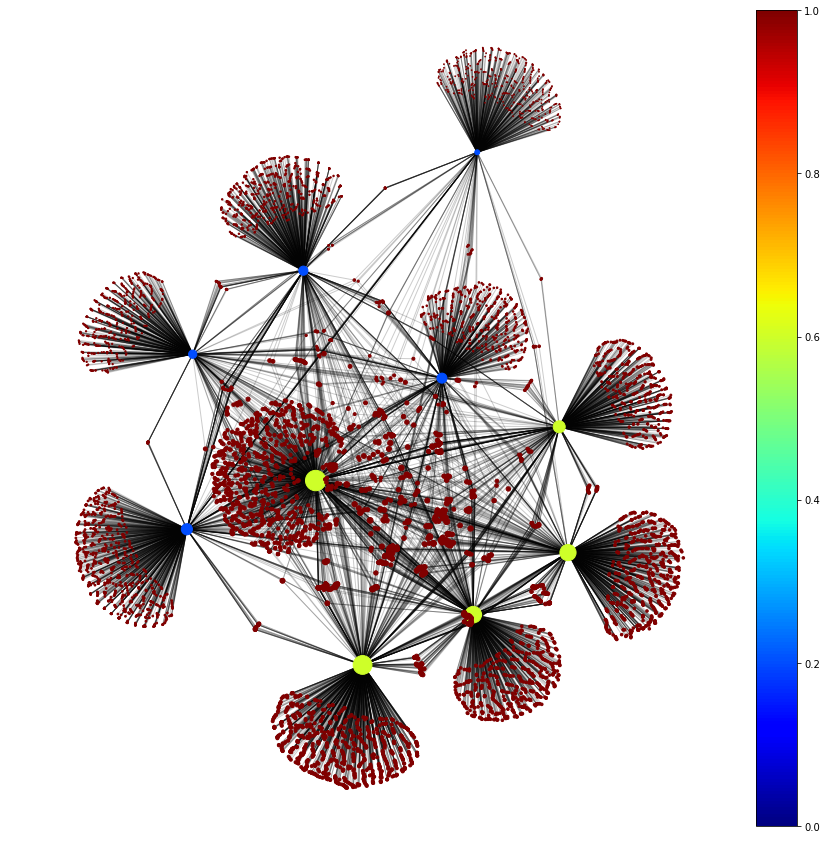

In [39]:
pos = nx.spring_layout(grafo)
centralidades = nx.eigenvector_centrality_numpy(grafo, weight='weight')
node_color = [v['cor'] for i,v in grafo.nodes(data=True)]
node_size = [v * 1000 for v in centralidades.values()]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo, pos=pos, alpha=0.2)
no = nx.draw_networkx_nodes(grafo, pos=pos, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=0.0, vmax=1.0,
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')